In [182]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import pandas as pd
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn import linear_model 
import warnings
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

In [33]:
# Read data from txt file, headers have spaces in them..
data = pd.read_csv('case1Data.txt', sep=",")
x_new = pd.read_csv('case1Data_Xnew.txt', sep=",")

# Explorative data analysis

## Training data

In [37]:
print("Shape", data.shape)
# convert datatypes
data = data.apply(lambda x: x.astype('float64') if 'x' in x.name else x)
data = data.apply(lambda x: x.astype('category') if 'C' in x.name else x)
data.head()

Shape (100, 101)


,y,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,...,x_91,x_92,x_93,x_94,x_95,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5
0,90.685036,NaN,NaN,-3.978178,-1.504027,-14.986790,0.651581,-37.878245,16.213807,-3.965437,...,-7.032047,6.319109,NaN,26.197445,-9.913837,H,H,I,K,J
1,60.844445,26.204958,11.185962,-8.247602,-3.875866,-11.329702,2.637900,-39.617497,NaN,-2.442164,...,-13.437474,NaN,-12.880342,25.924603,-7.015803,K,H,J,G,G
2,18.062345,18.560873,11.355342,-9.370161,-3.745315,-16.292421,-1.831774,-37.584605,14.411348,-2.376175,...,-12.291624,2.664209,-15.803518,24.293073,-14.795709,I,H,G,H,G
3,-8.139839,31.896496,10.069040,-9.484426,-1.512786,-11.421909,-5.649180,-42.830037,18.403197,-7.791762,...,-13.253436,5.004891,-13.879328,25.954304,-9.365574,NaN,H,K,K,G
4,-4.994792,25.400286,NaN,-3.600959,-2.615988,-15.455676,-4.950816,-39.932456,NaN,-7.341165,...,NaN,5.101262,-16.938532,22.611184,-17.240003,G,H,H,K,H


#### Missing values
* Lots of them, how to handle?
* Assume they are missing at random
* Deletion, imputation or model based?
* Deletion: Will lose too much information
* Imputation: Perhaps, but chose carefully. Look at histogram of each feature for continous. For categorical, consider just making NaN into a category in itself, or remove?

Number of features with missing values = 95
Total number of missing values = 1381


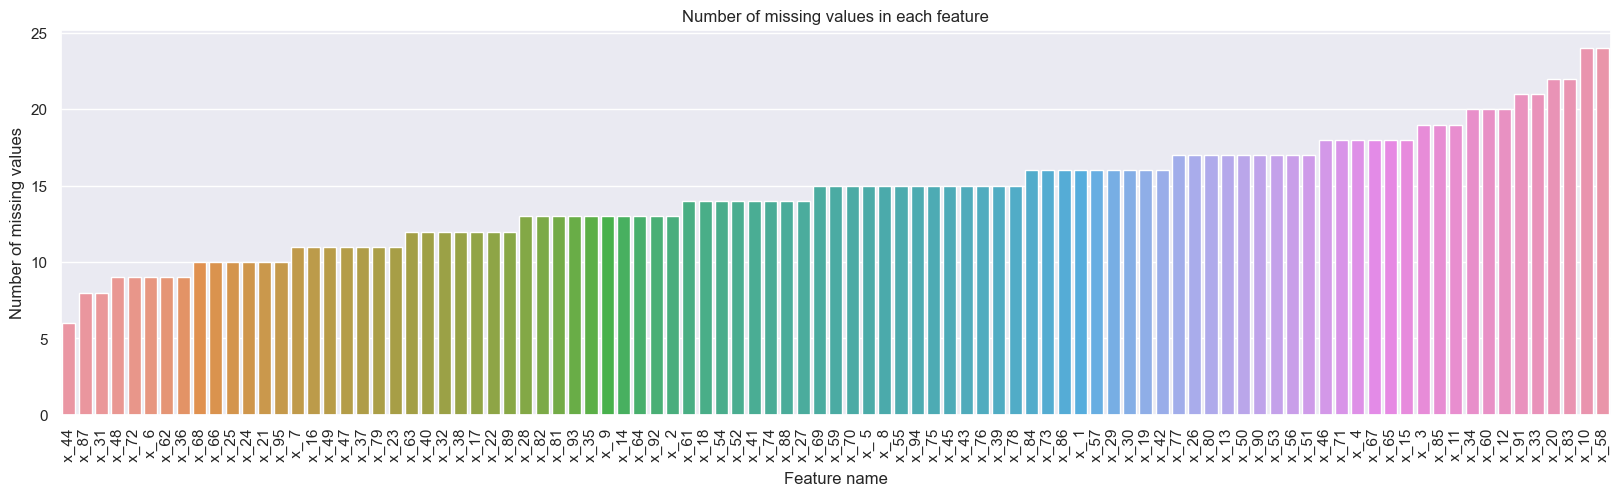

In [42]:
# Count plot of variables with missing values
missing = data.isnull().sum()
missing = missing[missing > 0]
print("Number of features with missing values =", missing.shape[0])
print("Total number of missing values =", missing.sum())
missing.sort_values(inplace=True)
plt.figure(figsize=(20, 5))
plt.title("Number of missing values in each feature")
plt.xlabel("Feature name")
plt.ylabel("Number of missing values")
sns.barplot(x=missing.index, y=missing.values)
plt.xticks(rotation=90)
plt.show()

/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/sea

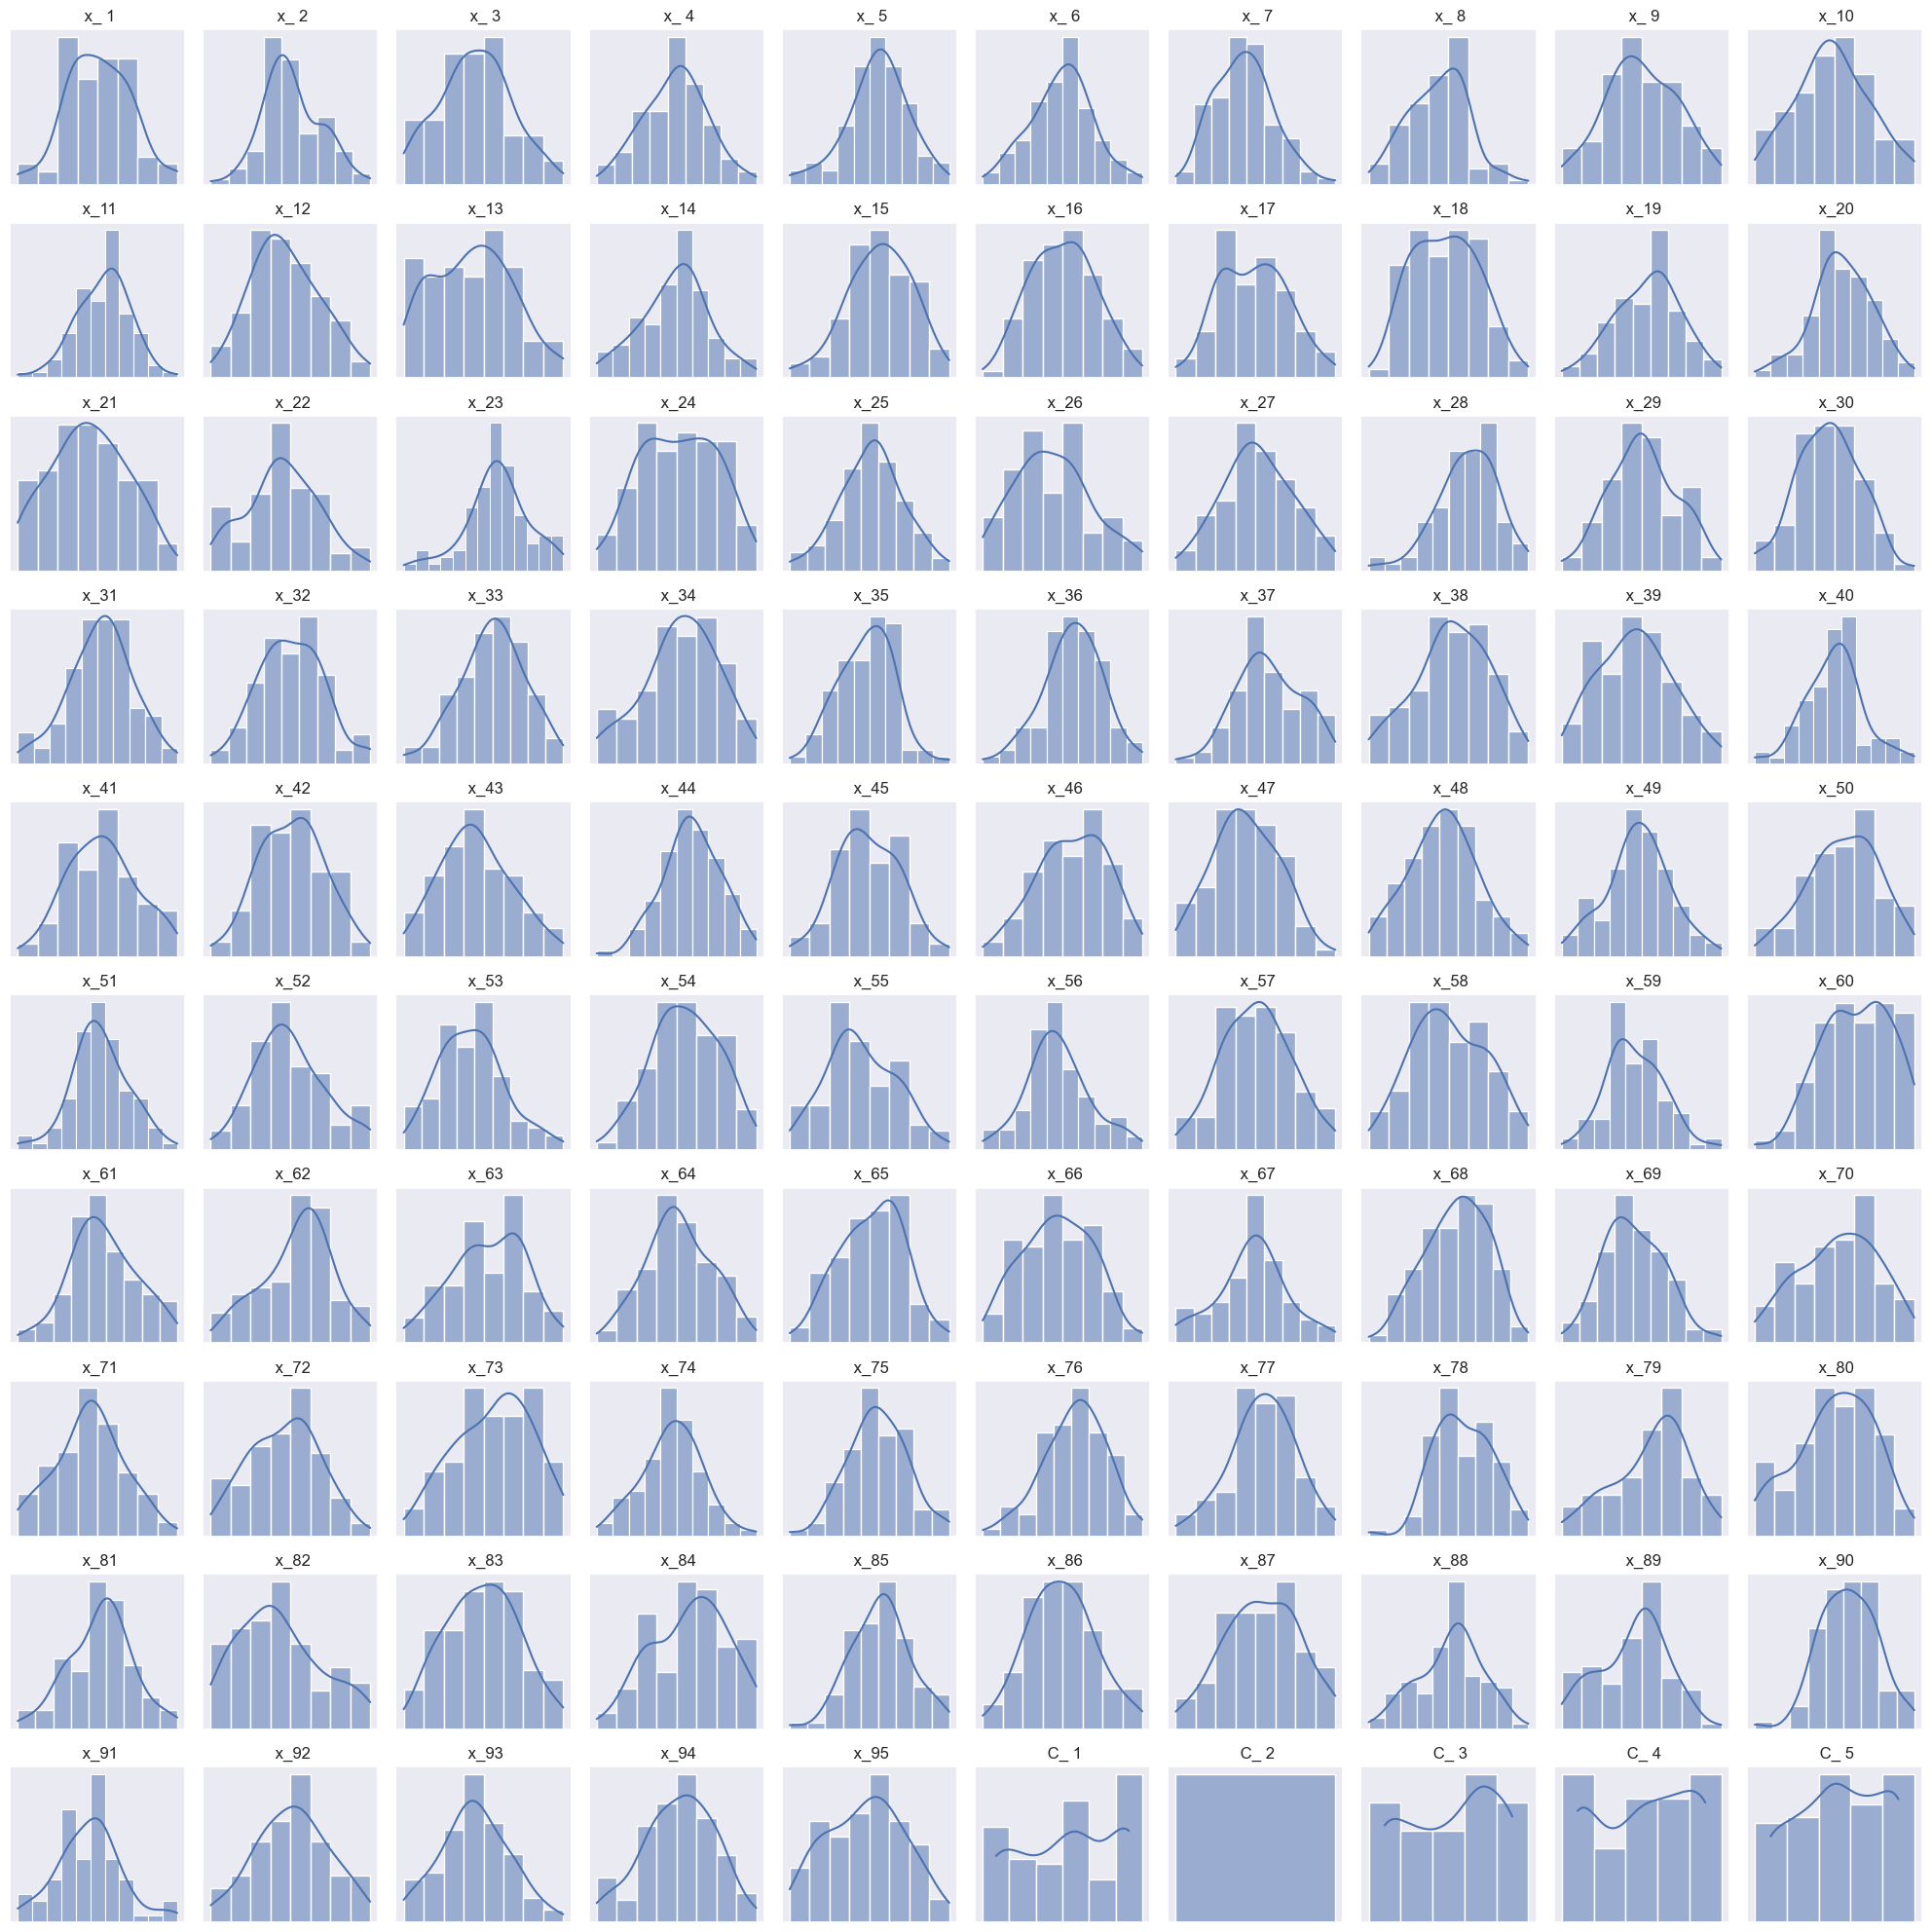

In [6]:
# histogram of each feature with missing values
features = [x for x in data.columns if x != 'y'] 
plt.figure(figsize=(20, 20))
for i, feature in enumerate(features):
    plt.subplot(10, 10, i+1)
    plt.title(feature)
    sns.histplot(data[feature], kde=True)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/sea

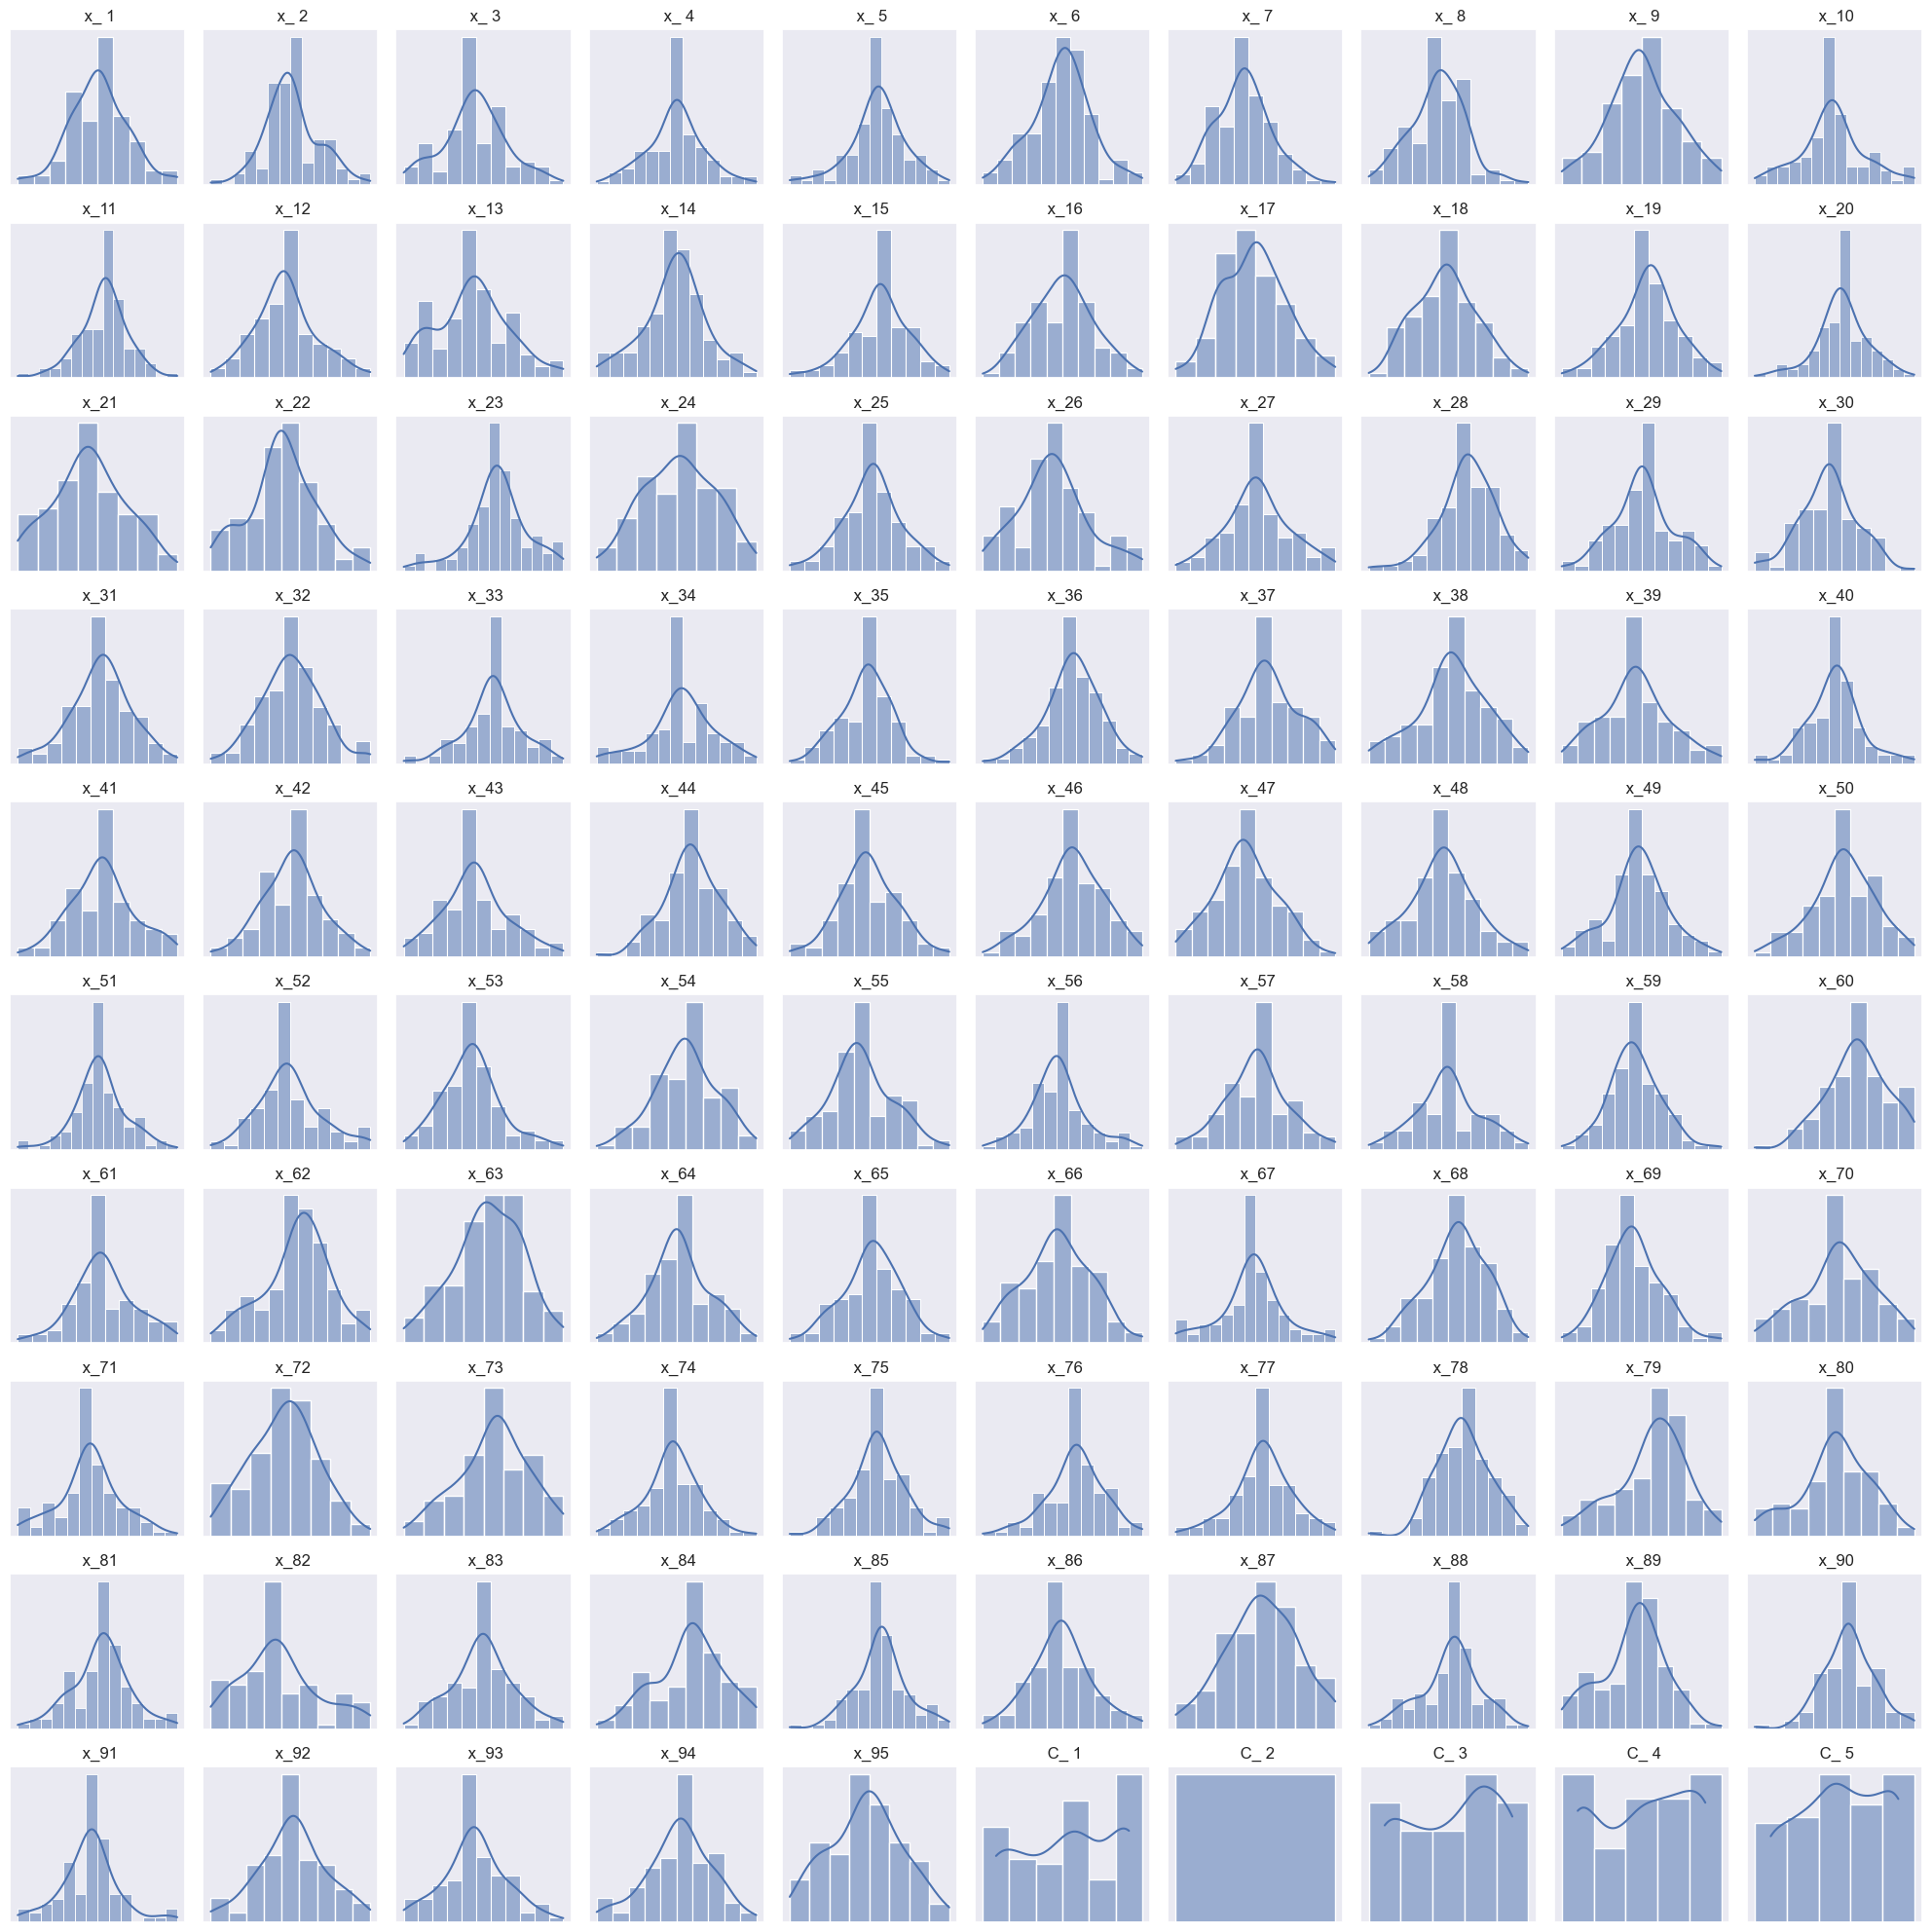

In [17]:
for feature in features:
    if data[feature].dtype == 'float64':
        data[feature] = data[feature].fillna(data[feature].mean())

# Histogram of each feature after filling missing values with mean
plt.figure(figsize=(20, 20))
for i, feature in enumerate(features):
    plt.subplot(10, 10, i+1)
    plt.title(feature)
    sns.histplot(data[feature], kde=True)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

We see a lot of missing values. Let's try to remove rows that have more than 15 missing values:

In [218]:
nan_counts = data.isnull().sum(axis=1)
nan_counts.value_counts()
df_drop = data[nan_counts <= 20]
df_drop

,y,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,...,x_91,x_92,x_93,x_94,x_95,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5
0,90.685036,NaN,NaN,-3.978178,-1.504027,-14.986790,0.651581,-37.878245,16.213807,-3.965437,...,-7.032047,6.319109,NaN,26.197445,-9.913837,H,H,I,K,J
1,60.844445,26.204958,11.185962,-8.247602,-3.875866,-11.329702,2.637900,-39.617497,NaN,-2.442164,...,-13.437474,NaN,-12.880342,25.924603,-7.015803,K,H,J,G,G
2,18.062345,18.560873,11.355342,-9.370161,-3.745315,-16.292421,-1.831774,-37.584605,14.411348,-2.376175,...,-12.291624,2.664209,-15.803518,24.293073,-14.795709,I,H,G,H,G
3,-8.139839,31.896496,10.069040,-9.484426,-1.512786,-11.421909,-5.649180,-42.830037,18.403197,-7.791762,...,-13.253436,5.004891,-13.879328,25.954304,-9.365574,NaN,H,K,K,G
4,-4.994792,25.400286,NaN,-3.600959,-2.615988,-15.455676,-4.950816,-39.932456,NaN,-7.341165,...,NaN,5.101262,-16.938532,22.611184,-17.240003,G,H,H,K,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,12.574444,24.821083,14.377228,-7.899269,-5.531786,NaN,-3.732251,NaN,15.752089,NaN,...,-21.322369,4.998234,NaN,NaN,-11.750148,I,H,J,G,G
96,-109.414997,20.848176,9.238049,-11.921478,-6.374971,-18.648810,-3.019048,-41.358696,8.435083,-5.864114,...,NaN,2.597797,-17.732465,20.164049,-15.924279,I,H,K,I,K
97,-11.548116,27.160523,10.134287,-10.920363,-3.231409,-18.474369,-2.431349,-38.280634,21.150995,-2.531643,...,-13.586151,8.293394,-17.020511,23.697288,-10.619427,NaN,H,I,K,J
98,-35.263761,20.391153,10.180320,NaN,-5.296246,-17.612480,-6.472314,-38.292821,12.740686,NaN,...,-16.653055,NaN,-17.575742,22.101534,-18.731196,I,H,K,H,G


#### Exploration of target variable

/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


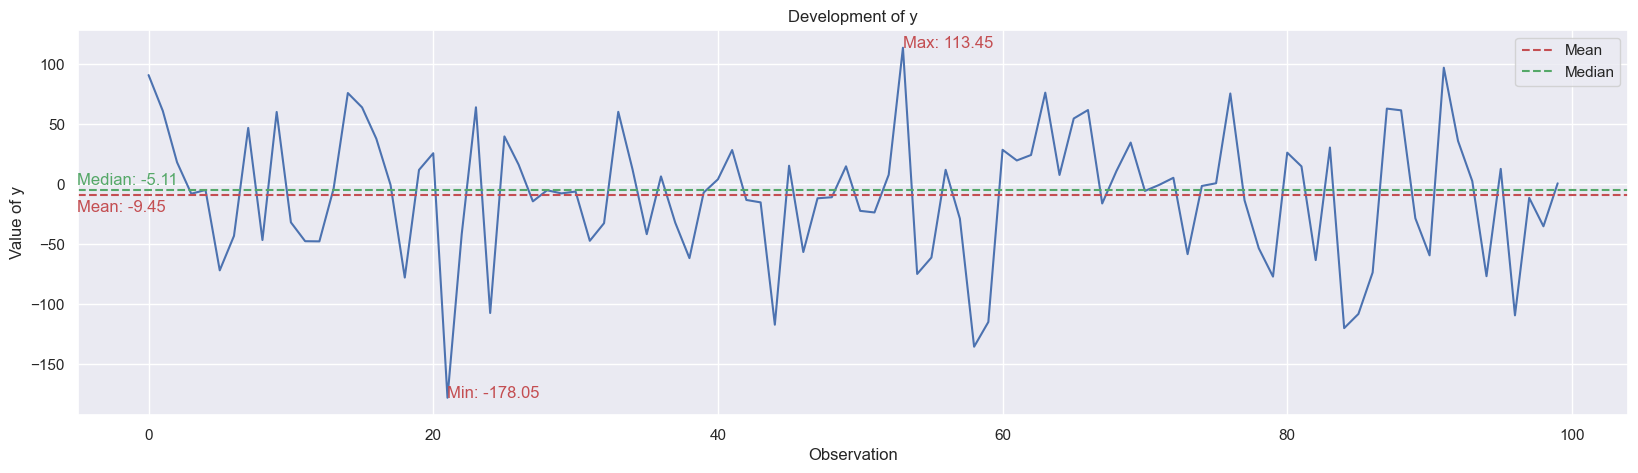

In [17]:
# Development of y over time
plt.figure(figsize=(20, 5))
plt.title("Development of y")
plt.xlabel("Observation")
plt.ylabel("Value of y")
sns.lineplot(x=data.index, y=data.y)
# min and max
plt.text(data.y.idxmax(), data.y.max(), f'Max: {round(data.y.max(),2)}', c = 'r')
plt.text(data.y.idxmin(), data.y.min(), f'Min: {round(data.y.min(),2)}', c = 'r')
# mean and median
plt.axhline(data.y.mean(), color='r', linestyle='--', label='Mean')
plt.text(-5, data.y.mean()-14, f'Mean: {round(data.y.mean(),2)}', c = 'r')
plt.axhline(data.y.median(), color='g', linestyle='--', label='Median')
plt.text(-5, data.y.median()+4, f'Median: {round(data.y.median(),2)}', c = 'g')
plt.legend()
plt.show()

#### Feature selection
* How to handle numerical vs categorical features? 1-hot encode categorical features perhaps?
* Which techniques to use?
* Regularization, Ridge Regression, Shrink parameters. How to chose optimal Lambda value? 
* Ragularization, Lasso Regression, Remove parameters. How to chose optimal Lambda value? 
* **Elastic net, mix of the 2 above.** How to chose optimal lambda and alpha values?
* Forward vs Backward Selection
* Clustering of features
* PCA
* Feature assessment, Bonferroni Correction, FDR, Benjamini Hochbergs.

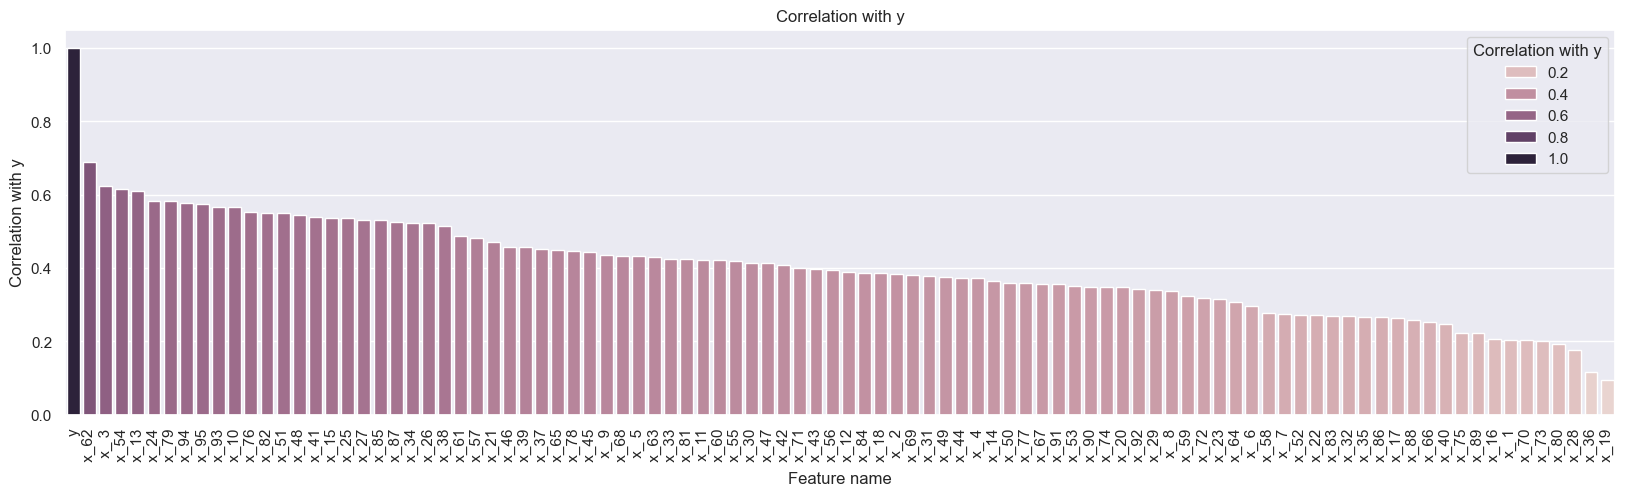

In [89]:
# correlation analysis
data_num = data.select_dtypes(include=['float64'])
corr = data_num.corr()
# sort corr by y
corr = corr.sort_values(by='y', ascending=False)
# barplot of correlation with y
plt.figure(figsize=(20, 5))
plt.title("Correlation with y")
plt.xlabel("Feature name")
plt.ylabel("Correlation with y")
sns.barplot(x=corr.index, y=corr.y, hue=corr.y, dodge=False)
plt.legend(loc='upper right', title='Correlation with y')
plt.xticks(rotation=90)
plt.show()

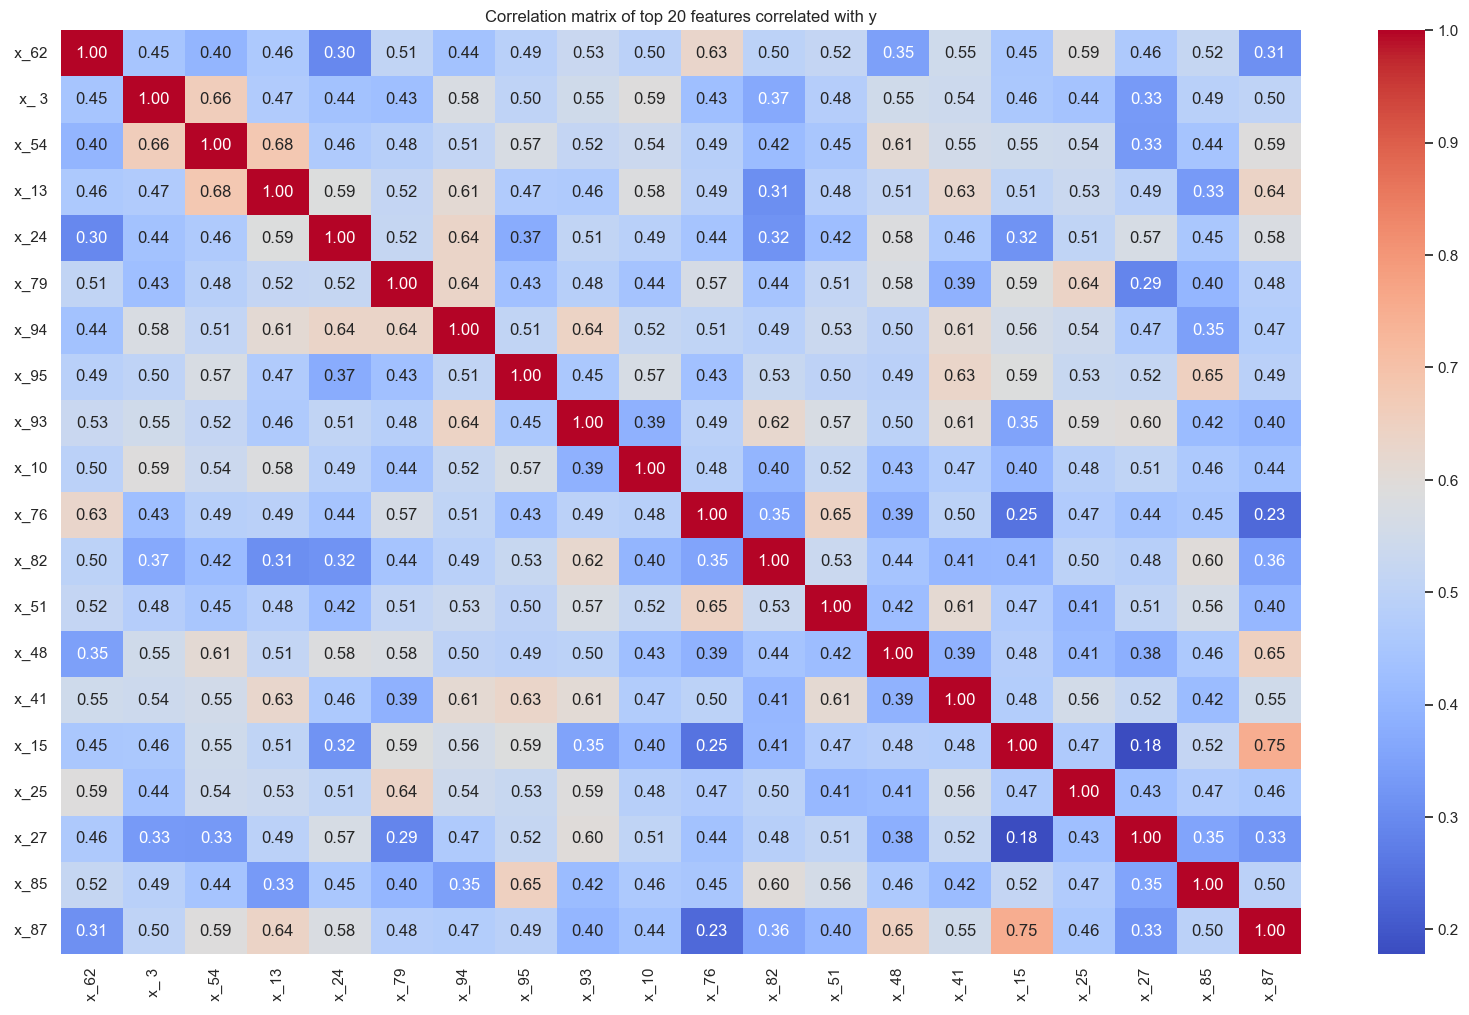

In [90]:
# filter top 20 correlated features with y
top20_corr = corr.y[1:21]
# plot the correlation matrix between these features
plt.figure(figsize=(20, 12))
plt.title("Correlation matrix of top 20 features correlated with y")
sns.heatmap(data_num[top20_corr.index].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

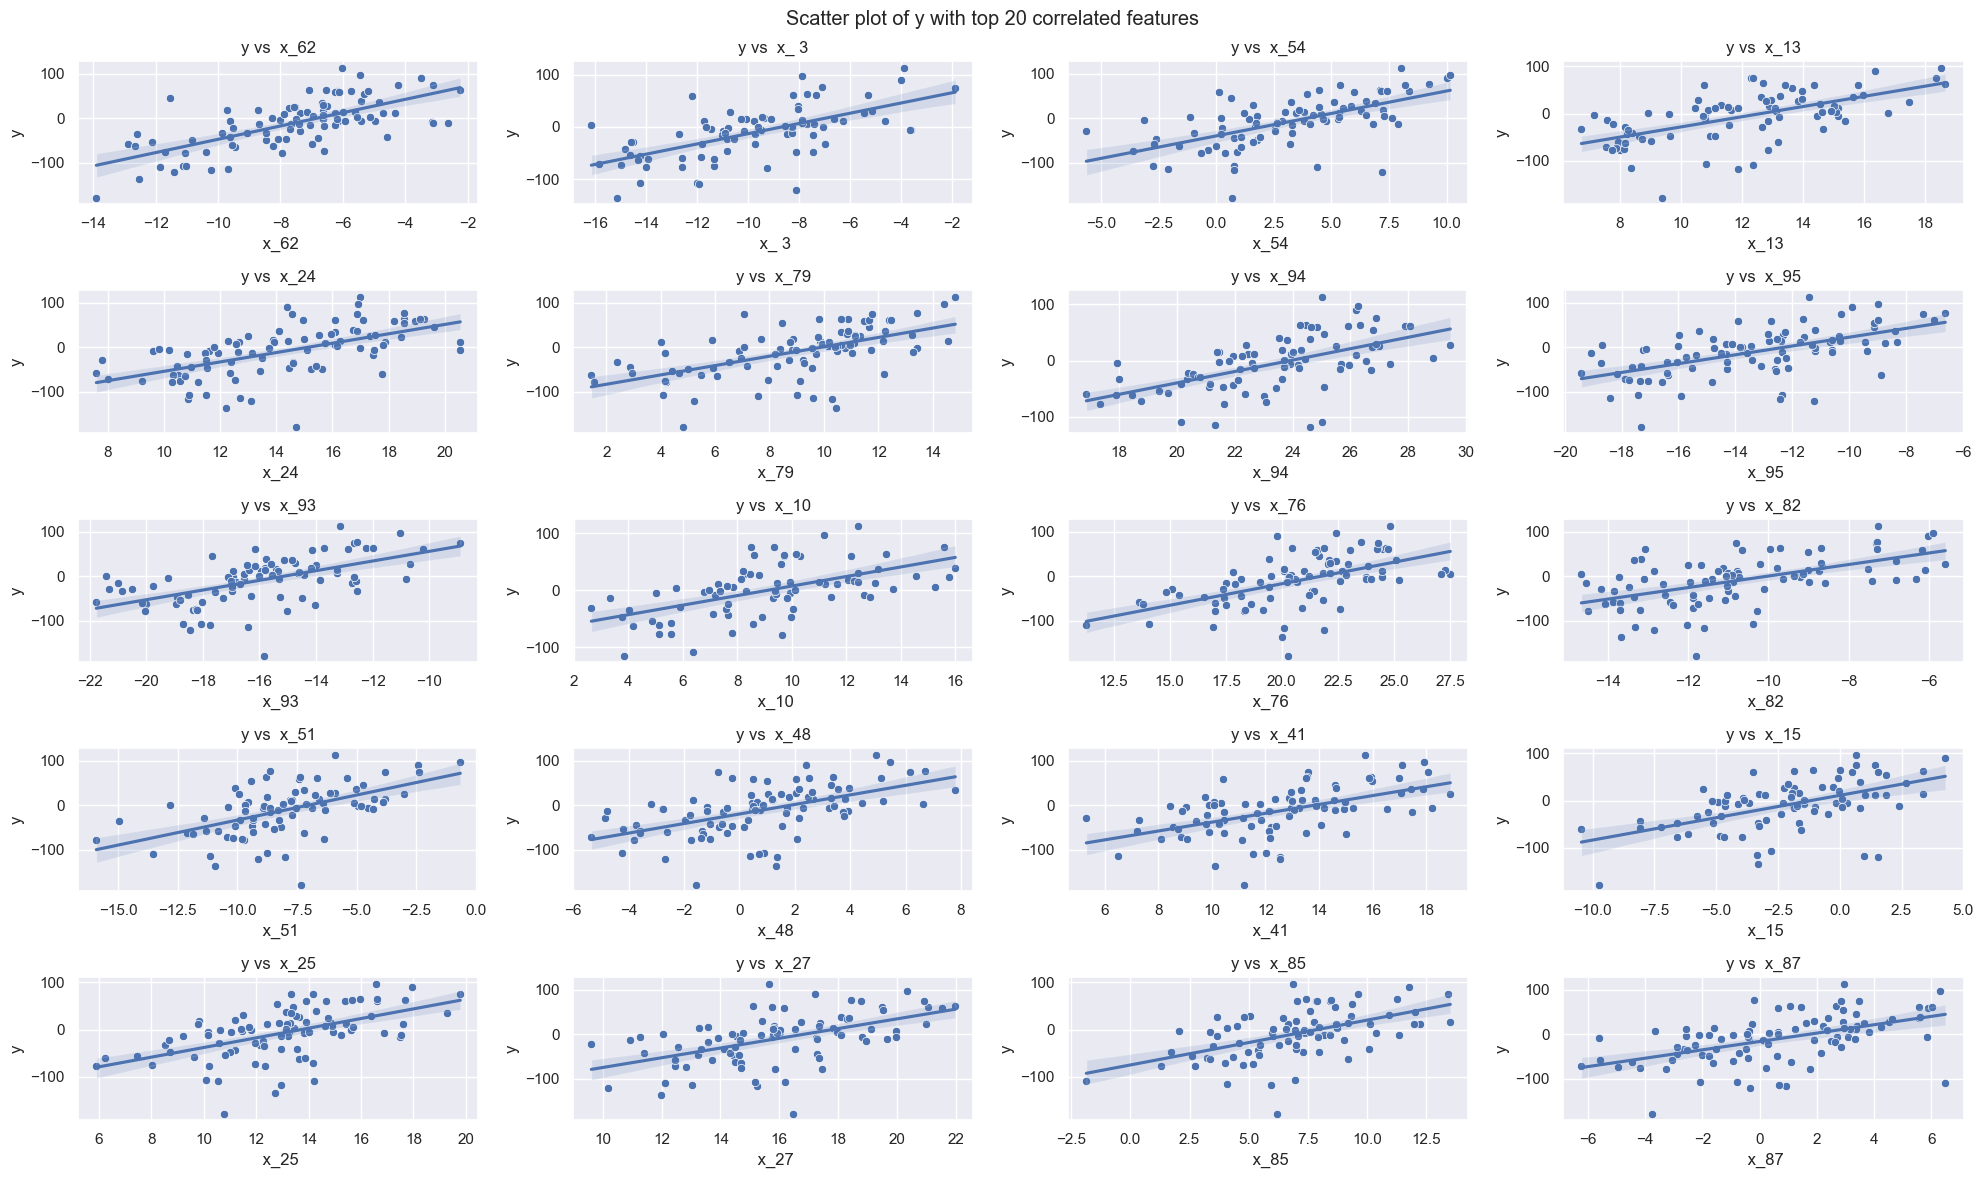

In [91]:
# scatter plot of y with top 20 correlated features in 5x4 subplot
plt.figure(figsize=(20, 12))
plt.suptitle("Scatter plot of y with top 20 correlated features")
for i, col in enumerate(top20_corr.index):
    plt.subplot(5, 4, i+1)
    sns.scatterplot(x=data[col], y=data.y)
    plt.title(f"y vs {col}")
    # fit line
    sns.regplot(x=data[col], y=data.y, scatter=False)
plt.tight_layout()
plt.show()

/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pa

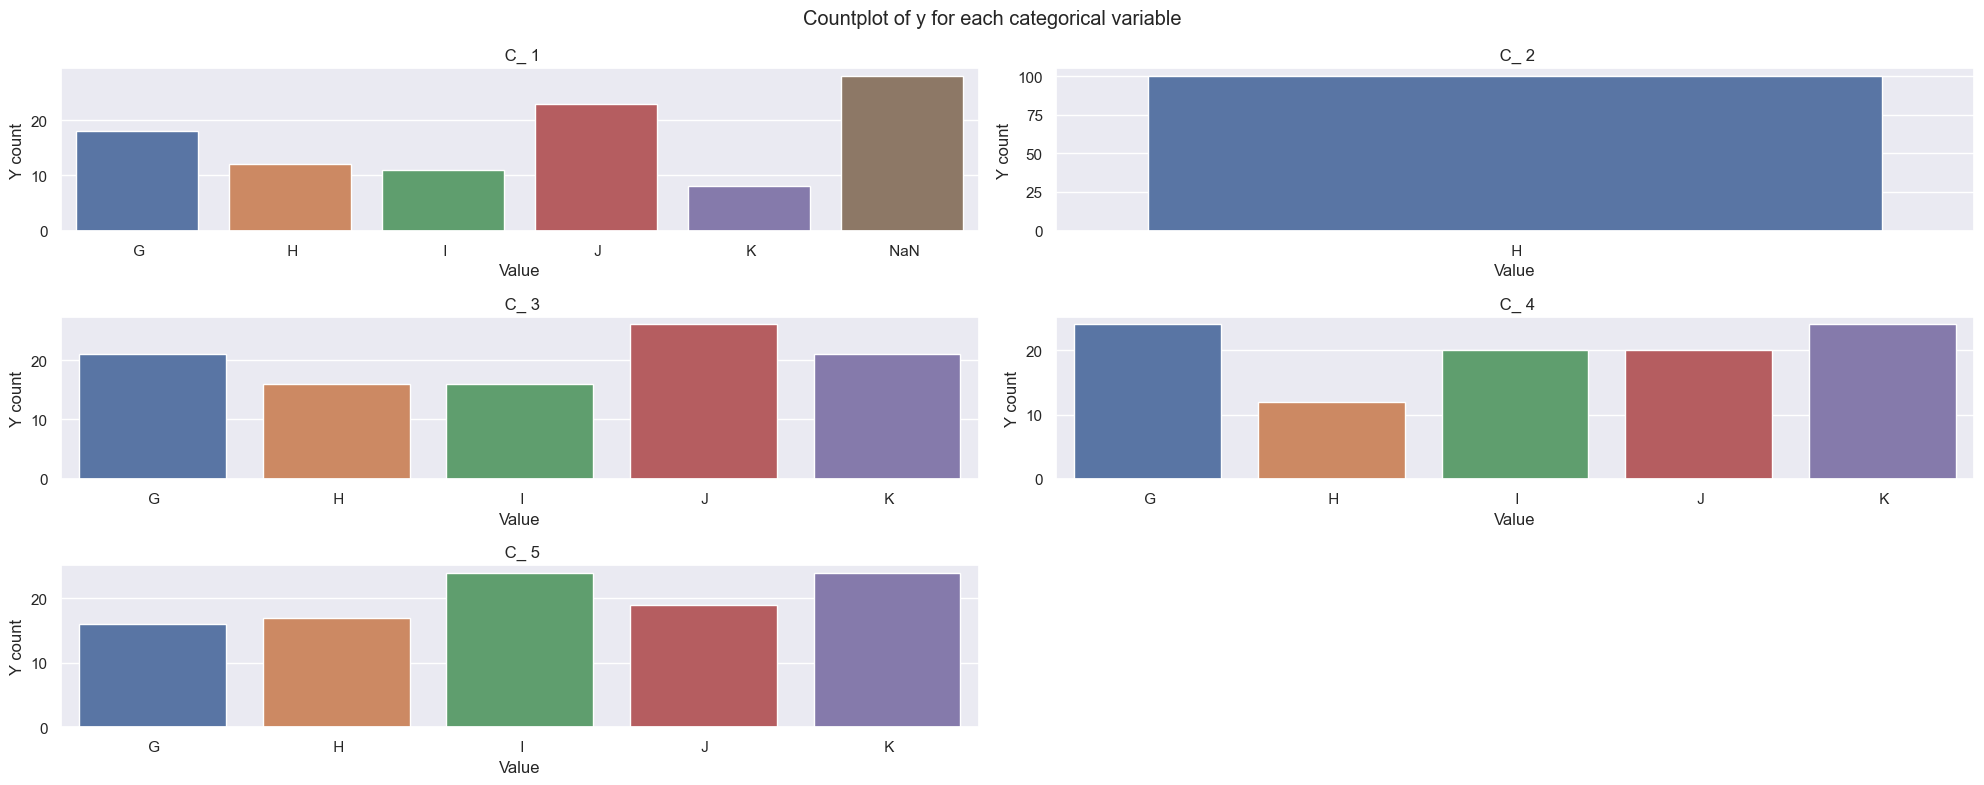

In [219]:
data_cat = data.select_dtypes(include=['category'])
# subplot for each categorical variable, countplot of y
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 8))
fig.suptitle("Countplot of y for each categorical variable")
for i, ax in enumerate(axes.flatten()):
    if i < data_cat.shape[1]:
        sns.countplot(x=data_cat.iloc[:, i], ax=ax)
        ax.set_title(data_cat.columns[i])
        ax.set_xlabel("Value")
        ax.set_ylabel("Y count")
    else:
        fig.delaxes(ax)
plt.tight_layout()
plt.show()

In [53]:
NumberOfNaN = data_cat.apply(lambda x: x.str.contains(' NaN').sum())

In [273]:
df = pd.DataFrame(data)

# Extract names of categorical columns
categorical_columns = [' C_ 1', ' C_ 2', ' C_ 3', ' C_ 4', ' C_ 5']  # Add more if needed

# Instantiate the BinaryEncoder with categorical columns
encoder = ce.BinaryEncoder(cols=categorical_columns)

# Fit and transform the data
data_encoded = encoder.fit_transform(df)

In [249]:
df = pd.DataFrame(data)

# Identify categorical variables
categorical_columns = [' C_ 1', ' C_ 2', ' C_ 3', ' C_ 4', ' C_ 5']  # Add more if needed

# Perform one-hot encoding for categorical variables
one_hot_encoded = pd.get_dummies(df[categorical_columns])

# Drop the original categorical columns from the DataFrame
df = df.drop(columns=categorical_columns)

# Concatenate the one-hot encoded columns with the original DataFrame
data_encoded = pd.concat([df, one_hot_encoded], axis=1)

In [274]:
data_model = data_encoded.drop(columns=['y'], inplace=False)

In [275]:
X = data_model.values.tolist()
y = data_encoded['y'].values.tolist()

In [276]:
imputer = IterativeImputer(random_state=0)#KNNImputer()
X_imputed = imputer.fit_transform(X)
[n,p] = X_imputed.shape


/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Text(0.5, 1.0, 'Crossvalidated MSE of Elastic Net Fit Alpha = 1.00')

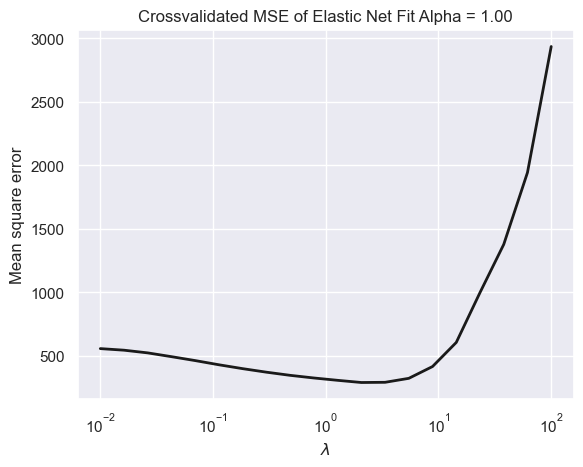

In [277]:
# set up a range of lambdas and an alpha value
alpha = 1.0
lambdas = np.logspace(-2, 2, num=20)

with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
    warnings.simplefilter("ignore")

    #Run the elasticNet model. You can implement Crossvalidation yourself or look at ElasticNetCV
    model = linear_model.ElasticNetCV(cv=5, l1_ratio = alpha, alphas=lambdas).fit(X_imputed, y)
    
plt.figure()
plt.semilogx(model.alphas_, model.mse_path_.mean(axis=-1), 'k',label='Average across the folds', linewidth=2)
plt.xlabel(r'$\lambda$')
plt.ylabel('Mean square error')
plt.title('Crossvalidated MSE of Elastic Net Fit Alpha = %.2f' % alpha)

In [278]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Instantiate the ElasticNet regression model
elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=1.0, max_iter=3000)  # Alpha is the regularization strength (hyperparameter), l1_ratio is the mixing parameter
#elastic_net_model = linear_model.ElasticNetCV()

# Fit the model to the training data
elastic_net_model.fit(X_train, y_train)

# Predict on the testing data
y_pred = elastic_net_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 241.73240777639785


## Test data, X New

In [115]:
print("Shape", x_new.shape)
# convert datatypes
x_new = x_new.apply(lambda x: x.astype('float64') if 'x' in x.name else x)
x_new = x_new.apply(lambda x: x.astype('category') if 'C' in x.name else x)
x_new.head()

Shape (1000, 100)


,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,x_10,...,x_91,x_92,x_93,x_94,x_95,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5
0,25.971128,10.429886,-10.660376,-3.582531,NaN,NaN,-36.779939,NaN,-7.351115,NaN,...,-11.795808,2.555591,NaN,23.179880,-15.602604,G,H,G,J,NaN
1,25.758732,11.887546,-9.844684,-1.581865,-16.918897,-4.046057,-45.243955,13.571447,-9.491872,9.277601,...,-13.024096,3.842341,-16.125888,20.753334,-12.107064,I,H,NaN,NaN,H
2,23.782500,7.347982,NaN,-5.679517,-17.396745,-6.266300,NaN,NaN,-4.723122,5.481726,...,-16.494321,NaN,-17.896117,22.476679,-11.235097,NaN,H,NaN,H,K
3,19.074196,NaN,-11.174759,-10.383339,-18.526151,-4.435927,-42.421554,14.394625,-7.643014,9.247063,...,-15.797810,1.072284,-22.433262,22.744498,-14.742469,G,H,K,K,J
4,23.730968,NaN,-10.863462,-0.875571,-16.279798,-2.969740,-34.913373,8.506439,-1.781169,NaN,...,-14.149051,3.292523,-12.151728,22.667303,NaN,H,H,J,H,G


Number of features with missing values 95


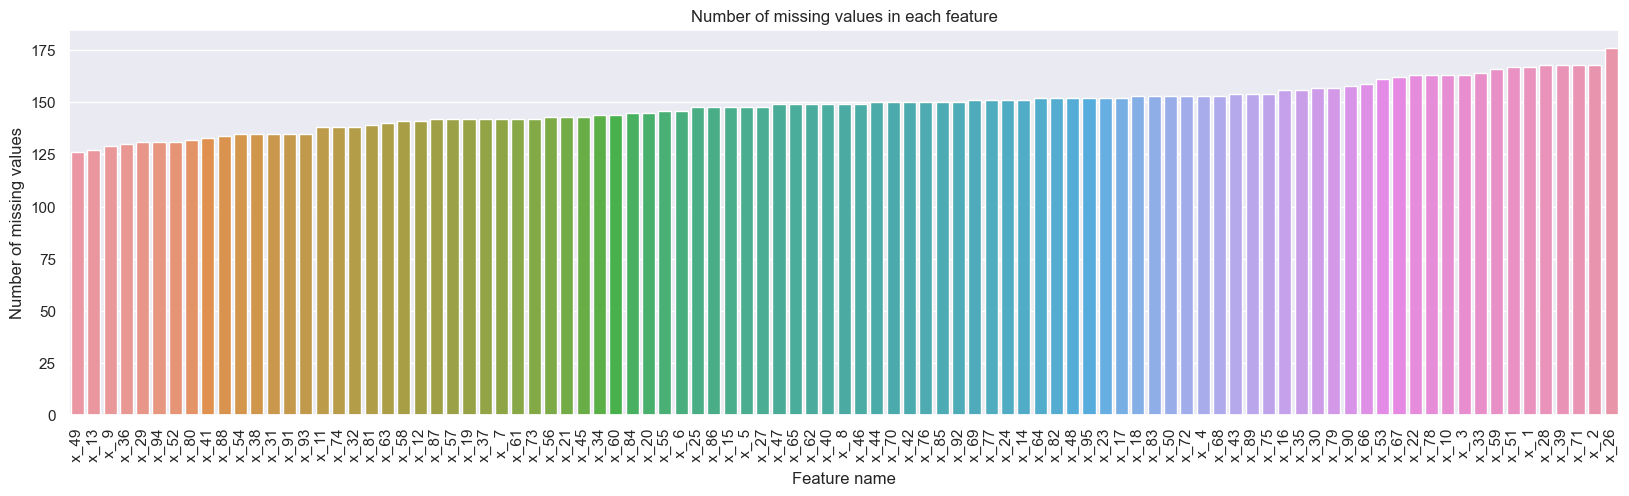

In [116]:
# Count plot of variables with missing values
missing = x_new.isnull().sum()
missing = missing[missing > 0]
print("Number of features with missing values", missing.shape[0])
missing.sort_values(inplace=True)
plt.figure(figsize=(20, 5))
plt.title("Number of missing values in each feature")
plt.xlabel("Feature name")
plt.ylabel("Number of missing values")
sns.barplot(x=missing.index, y=missing.values)
plt.xticks(rotation=90)
plt.show()

/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pa

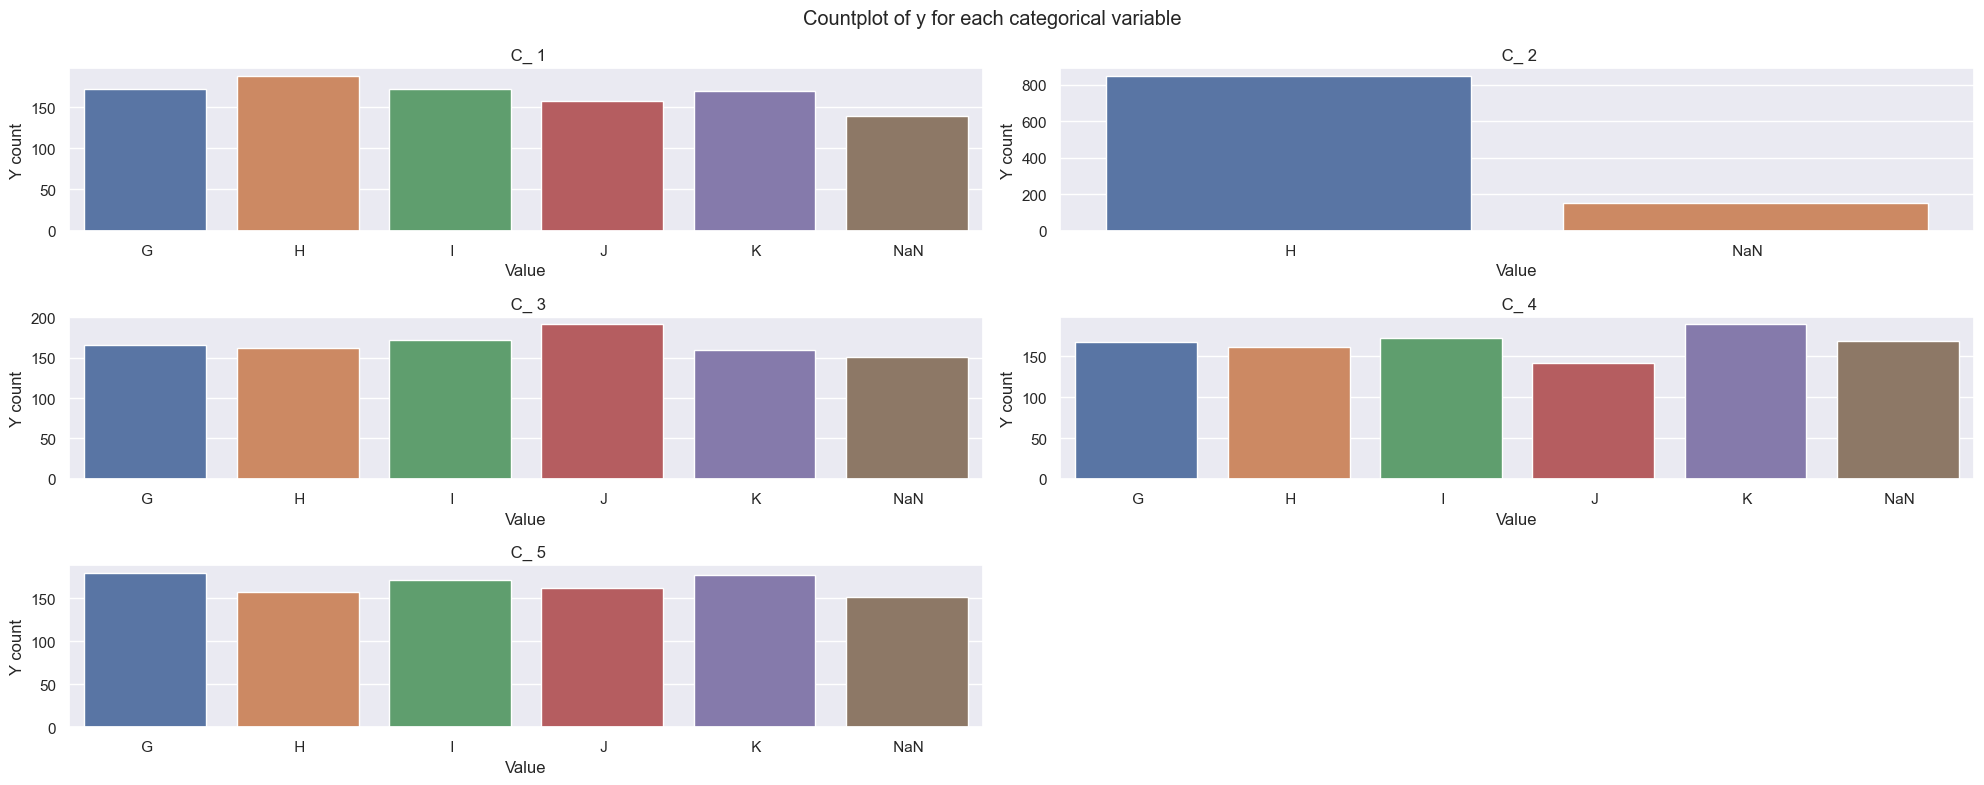

In [117]:
data_cat_new = x_new.select_dtypes(include=['category'])
# subplot for each categorical variable, countplot of y
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 8))
fig.suptitle("Countplot of y for each categorical variable")
for i, ax in enumerate(axes.flatten()):
    if i < data_cat_new.shape[1]:
        sns.countplot(x=data_cat_new.iloc[:, i], ax=ax)
        ax.set_title(data_cat_new.columns[i])
        ax.set_xlabel("Value")
        ax.set_ylabel("Y count")
    else:
        fig.delaxes(ax)
plt.tight_layout()
plt.show()

# Predictions
* Cross Validation, how to chose optimal K?
* Center and standardize within each fold
* Regression with Elastic Net
* Estimate prediction error RMSE